In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.functional import f1
from string import punctuation
from nltk import TweetTokenizer
import pandas as pd
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from gensim.models import FastText
fasttext_embedder = FastText()
import numpy as np

In [ ]:
col_names = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'fav', 'stcount', 'foll', 'frien', 'listcount']

In [ ]:
positive_df = pd.read_csv("/content/drive/MyDrive/positive.csv", header=None, sep=';', names=col_names, index_col=0)

In [ ]:
positive_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount
id,,,,,,,,,,,
408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [ ]:
negative_df = pd.read_csv("/content/drive/MyDrive/negative.csv", header=None, sep=';', names=col_names, index_col=0)

In [ ]:
negative_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount
id,,,,,,,,,,,
408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [ ]:
all_df = pd.concat([positive_df, negative_df], ignore_index=True)

In [ ]:
tokenized_texts = []
for i in tqdm(range(len(all_df))):
  tokenized_texts.append(word_tokenize(all_df['text'].iloc[i]))

100%|██████████| 226834/226834 [01:02<00:00, 3630.41it/s]


In [ ]:
clean_tokenized_texts = []
for text in tokenized_texts:
    text_tokens = []
    for thing in text:
        if thing not in punctuation:
            text_tokens.append(thing)
    clean_tokenized_texts.append(text_tokens)

In [ ]:
all_df.insert(3, 'text_tokenized', clean_tokenized_texts)

In [ ]:
all_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount,text_tokenized
0,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,"[@first_timee, хоть, я, и, школота, но, поверь..."
1,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,"[Да, все-таки, он, немного, похож, на, него, Н..."
2,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,"[RT, @KatiaCheh, Ну, ты, идиотка, я, испугалас..."
3,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,"[RT, @digger2912, Кто, то, в, углу, сидит, и, ..."
4,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,"[@irina_dyshkant, Вот, что, значит, страшилка,..."


**Модель 1**

In [ ]:
train_data, val_data = train_test_split(all_df, test_size=0.2)

In [ ]:
vocab = Counter()
for tokens in all_df['text_tokenized']:
        vocab.update(list([token.lower() for token in tokens]))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 302594


In [ ]:
filtered_vocab = set()
for token in vocab:
    if vocab[token] > 10:
        filtered_vocab.add(token)
print('уникальных токенов, встретившихся более десяти раз:', len(filtered_vocab))

уникальных токенов, встретившихся более десяти раз: 17767


In [ ]:
word2id = {'PAD':0}

for token in filtered_vocab:
    word2id[token] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class TweetDataset(Dataset):

    def __init__(self, dataset, symbol2id, DEVICE):
        self.dataset = dataset['text_tokenized'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [ ]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
batch = next(iter(train_iterator))
[id2word[int(i)] for i in batch[0][0]]

In [ ]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
test_batch = next(iter(val_iterator))

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded)
        feature_map_trigrams = self.trigrams(embedded)
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat_bigrams = self.bigrams2(concat)
        pooling = self.pooling(concat_bigrams)
        pooling = pooling.max(2)[0]

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[14622, 11431,  8448,  ...,     0,     0,     0],
        [ 2539,  9747,  2602,  ...,     0,     0,     0],
        [17122, 12720, 11031,  ...,     0,     0,     0],
        ...,
        [ 6227,  3954, 16561,  ...,     0,     0,     0],
        [11594,  4632,  1278,  ...,     0,     0,     0],
        [13491, 10207, 13148,  ...,     0,     0,     0]])


In [ ]:
loss = nn.BCELoss()

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() 
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [ ]:
model = CNN(len(word2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def train_eval(model, t_iterator, v_iterator, optimizer, criterion, epochs=20):
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []
    log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for i in range(epochs):
        print(f'\nEpoch {i}')
        print('Training...')
        epoch_loss = train(model, t_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, t_iterator, criterion)
        f1s.append(f1_on_train)
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, v_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)

        log['train_loss'] = losses
        log['val_loss'] = losses_eval    
        
        if i % 19 == 0:
            fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
            for i, (name, vals) in enumerate(log.items()):
                axs[i].plot(vals)
                axs[i].set_title(name)
            plt.show()
            log['val_f1'] = f1s_eval

    return losses, losses_eval, f1s, f1s_eval


Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.5801547432647032
Train loss: 0.5305020826450293
Train loss: 0.5065062051782241
Train loss: 0.49306129658822534
Train loss: 0.482626691118054

Evaluating on train...
Val loss: 0.44983211335013895, Val f1: 0.8090000152587891
Val loss: 0.44046218585276947, Val f1: 0.7988830208778381
Val loss: 0.43780030424778277, Val f1: 0.7957552671432495
Val loss: 0.4368877250084774, Val f1: 0.793415904045105
Val loss: 0.43584552475775795, Val f1: 0.7923219203948975

Evaluating on test...
Val loss: 0.49322064220905304, Val f1: 0.8836269378662109
Val loss: 0.4653392434120178, Val f1: 0.8292807936668396
Val loss: 0.45688854501797604, Val f1: 0.8131365776062012
Val loss: 0.45443328193255833, Val f1: 0.8048451542854309
Val loss: 0.4515104334462773, Val f1: 0.8010677099227905


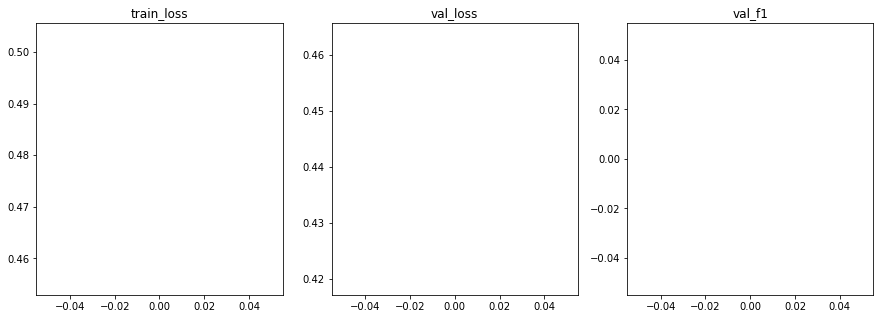


Epoch 1
Training...
Train loss: 0.44205108635565815
Train loss: 0.4333785128766212
Train loss: 0.42737341270996976
Train loss: 0.4247806848381921
Train loss: 0.42252507172096737

Evaluating on train...
Val loss: 0.4148438318687327, Val f1: 0.8181496262550354
Val loss: 0.4072722174983094, Val f1: 0.8076587915420532
Val loss: 0.4042230351613118, Val f1: 0.8052753806114197
Val loss: 0.40399532416741624, Val f1: 0.8026970028877258
Val loss: 0.40332066019376117, Val f1: 0.8020139932632446

Evaluating on test...
Val loss: 0.46322883665561676, Val f1: 0.8853946328163147
Val loss: 0.43958325771724477, Val f1: 0.8275721669197083
Val loss: 0.4310805075443708, Val f1: 0.8125941753387451
Val loss: 0.4292212017944881, Val f1: 0.8036899566650391
Val loss: 0.42633452063257044, Val f1: 0.8003819584846497

Epoch 2
Training...
Train loss: 0.4124770760536194
Train loss: 0.40636139978533203
Train loss: 0.4035592170862051
Train loss: 0.40062412662471797
Train loss: 0.3993337022504587

Evaluating on train.

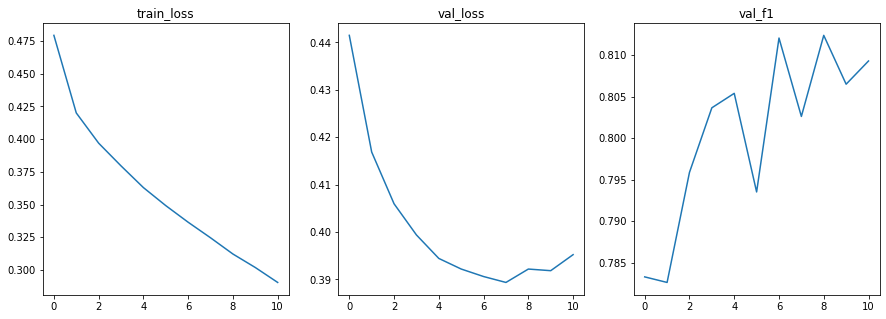


Epoch 11
Training...
Train loss: 0.2822591706233866
Train loss: 0.279719317736833
Train loss: 0.28023928203261816
Train loss: 0.2804391315515093
Train loss: 0.2813454371416706

Evaluating on train...
Val loss: 0.27061088821467233, Val f1: 0.9104476571083069
Val loss: 0.26697796237641486, Val f1: 0.898719310760498
Val loss: 0.265554769967611, Val f1: 0.8945586681365967
Val loss: 0.26513039808479144, Val f1: 0.8920466899871826
Val loss: 0.26444111969964257, Val f1: 0.8911242485046387

Evaluating on test...
Val loss: 0.4405669793486595, Val f1: 0.9128276705741882
Val loss: 0.42335009574890137, Val f1: 0.8518062233924866
Val loss: 0.41381118389276356, Val f1: 0.8356586694717407
Val loss: 0.41127282210758753, Val f1: 0.8270299434661865
Val loss: 0.40818825499577954, Val f1: 0.8227947950363159

Epoch 12
Training...
Train loss: 0.27212902289979596
Train loss: 0.27050423514151917
Train loss: 0.2703052588666861
Train loss: 0.27021075592195387
Train loss: 0.27063936748723877

Evaluating on trai

In [ ]:
train_eval(model, train_iterator, val_iterator, optimizer, criterion)

Добавим эмбеддинги

In [ ]:
fasttext_embedder.build_vocab(list(all_df['text_tokenized']))
fasttext_embedder.train(list(all_df['text_tokenized']), total_examples=len(all_df['text_tokenized']), epochs=10)

In [ ]:
fasttext_embeddings = np.zeros((len(word2id), 100))
for word in tqdm(word2id.keys()):
    try:
        fasttext_embeddings[word2id[word]] = fasttext_embedder.wv[word]
    except:
        pass

100%|██████████| 17768/17768 [00:00<00:00, 70384.85it/s]


Попробуем добавить дропаут и ReLU.

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, weights.shape[1])
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        bigrams = self.bigrams(embedded)
        trigrams = self.trigrams(embedded)
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        filal = self.dropout(self.relu(final))

        pooling = final.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
weights = np.zeros((len(word2id), 300))
torch.manual_seed(100)
np.random.seed(100)

In [ ]:
model = CNN(len(word2id), weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

device(type='cuda')

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)


Epoch 0
Training...
Train loss: 0.026323555694783434
Train loss: 0.026287084121419037
Train loss: 0.026552536954673436
Train loss: 0.026994670613956967
Train loss: 0.02730200919269145

Evaluating on train...
Val loss: 0.022515371880110574, Val f1: 1.0219913721084595
Val loss: 0.02256008656020614, Val f1: 1.0069071054458618
Val loss: 0.02275973538724849, Val f1: 1.0019851922988892
Val loss: 0.022630224299195003, Val f1: 0.9995831251144409
Val loss: 0.02272571386748004, Val f1: 0.9980790615081787

Evaluating on test...
Val loss: 1.1207385584712029, Val f1: 0.9021333456039429
Val loss: 1.1013084544855005, Val f1: 0.8479539752006531
Val loss: 1.0826490750679603, Val f1: 0.8326174020767212
Val loss: 1.0653341020856584, Val f1: 0.8247636556625366
Val loss: 1.0561918358911166, Val f1: 0.8222518563270569


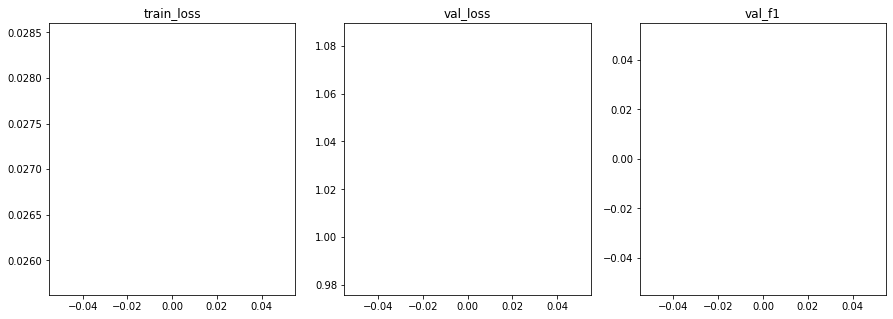


Epoch 1
Training...
Train loss: 0.024761902990148348
Train loss: 0.02413661144943773
Train loss: 0.024167558079800353
Train loss: 0.02453855425789416
Train loss: 0.025044359036603535

Evaluating on train...
Val loss: 0.023086428149219823, Val f1: 1.0210976600646973
Val loss: 0.02255056849748328, Val f1: 1.0061683654785156
Val loss: 0.021645251348113213, Val f1: 1.0017579793930054
Val loss: 0.021370333693117548, Val f1: 0.9993896484375
Val loss: 0.02131750582364099, Val f1: 0.9979560971260071

Evaluating on test...
Val loss: 1.223202459514141, Val f1: 0.9041379690170288
Val loss: 1.1983220612301546, Val f1: 0.8509412407875061
Val loss: 1.1701183456640978, Val f1: 0.8352153301239014
Val loss: 1.1586776563099452, Val f1: 0.8270164132118225
Val loss: 1.1439719024029644, Val f1: 0.8246270418167114

Epoch 2
Training...
Train loss: 0.022412418415222096
Train loss: 0.0221322077339974
Train loss: 0.02284961034400532
Train loss: 0.023176749632191317
Train loss: 0.02371784020215273

Evaluating o

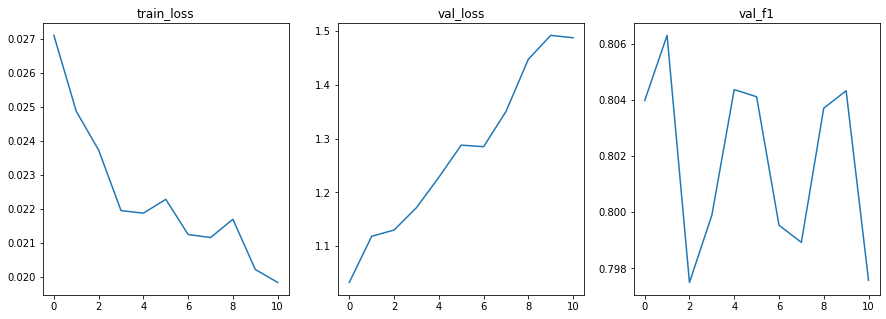


Epoch 11
Training...
Train loss: 0.019466539105290875
Train loss: 0.019394635573785374
Train loss: 0.01964338066486212
Train loss: 0.0203540074913729
Train loss: 0.020727403595743852

Evaluating on train...
Val loss: 0.018174913602278513, Val f1: 1.0229105949401855
Val loss: 0.018869049118264862, Val f1: 1.0075526237487793
Val loss: 0.019128479269476466, Val f1: 1.0021898746490479
Val loss: 0.0194666449771189, Val f1: 0.9996135234832764
Val loss: 0.019256671253677415, Val f1: 0.9981395602226257

Evaluating on test...
Val loss: 1.6744579523801804, Val f1: 0.8981949687004089
Val loss: 1.6456342164207907, Val f1: 0.8418687582015991
Val loss: 1.6339221550868108, Val f1: 0.82673180103302
Val loss: 1.5942264216286794, Val f1: 0.8182634115219116
Val loss: 1.5600553764538332, Val f1: 0.816285252571106

Epoch 12
Training...
Train loss: 0.020517230663886842
Train loss: 0.020547363272719624
Train loss: 0.02078672138472589
Train loss: 0.021207043800583417
Train loss: 0.020875369519766034

Evaluat

([0.027112890108164107,
  0.024877526331692934,
  0.023737322716984185,
  0.021956567725773608,
  0.021880938786636578,
  0.02228760664884964,
  0.02125247276461359,
  0.0211637198318089,
  0.021700652896981226,
  0.020223702000600568,
  0.019842613242524728,
  0.020630187883428977,
  0.020678005877128813,
  0.020761779891431666,
  0.020413711018274338,
  0.020486576733796783,
  0.020296934270038362,
  0.02033907516723436,
  0.01982345682139812,
  0.019704735053054402],
 [1.0327209062046474,
  1.1185503045717875,
  1.1301877485381233,
  1.1716768834326001,
  1.2282815840509202,
  1.2880757570266723,
  1.285161723030938,
  1.350567016336653,
  1.4477146572536892,
  1.492204221089681,
  1.4877318885591295,
  1.5253874791993036,
  1.6025006506178114,
  1.5934362729390463,
  1.7471361372205947,
  1.6990302668677435,
  1.766243675020006,
  1.692784481578403,
  1.808858002556695,
  1.7417601651615566],
 [tensor(0.9923, device='cuda:0'),
  tensor(0.9923, device='cuda:0'),
  tensor(0.9895, dev

In [ ]:
train_eval(model, train_iterator, val_iterator, optimizer, criterion)

Стало незначительно, но чуть лучше качество.

**Модель 2**

In [ ]:
sym_vocab = Counter()
for symbol in all_df['text']:
    sym_vocab.update(list(symbol))
print('Всего уникальных символов:', len(sym_vocab))

Всего уникальных символов: 456


In [ ]:
filtered_sym_vocab = set()

for symbol in sym_vocab:
    if sym_vocab[symbol] > 10:
        filtered_sym_vocab.add(symbol)
print('Уникальных символов, втретившихся больше 10 раз:', len(filtered_sym_vocab))

Уникальных символов, втретившихся больше 10 раз: 213


In [ ]:
symbol2id = {'PAD':0}

for symbol in filtered_sym_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [ ]:
class TweetDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset_tokens = dataset['text_tokenized'].values
        self.dataset_texts = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset_tokens[index])
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset_texts[index])
        sym_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, sym_ids, y

    def collate_fn(self, batch): 
      word_ids, sym_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_sym_ids = pad_sequence(sym_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_sym_ids, y

In [ ]:
train_dataset = TweetDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
val_dataset = TweetDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim, weights):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(in_features=100, out_features=80)

        self.sym_embedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        
        self.hidden = nn.Linear(in_features=80+80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word, symbols):
        word_embedded = self.word_embedding(word)
        mean_emb = torch.mean(word_embedded, dim=1)
        word_hidden = self.word_hidden(mean_emb)

        sym_embedded = self.sym_embedding(symbols)
        sym_embedded = sym_embedded.transpose(1,2)

        bigrams = self.bigrams(sym_embedded)
        trigrams = self.trigrams(sym_embedded)
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        
        pooling = final.max(2)[0] 
        logits = self.hidden(torch.cat((pooling, word_hidden), 1))
        logits = self.out(logits)      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    
    model.train()

    for i, (words, symbols, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(words, symbols)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return  epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator):   
            preds = model(words, symbols)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), len(symbol2id), 8, weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)


Epoch 0
Training...

Evaluating on train...

Evaluating on test...


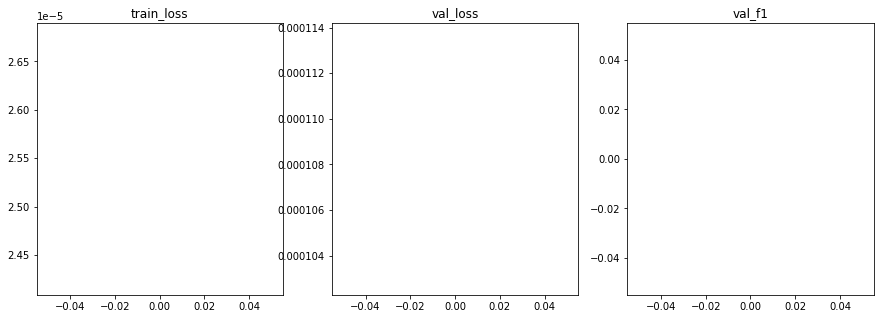


Epoch 1
Training...

Evaluating on train...

Evaluating on test...

Epoch 2
Training...

Evaluating on train...

Evaluating on test...

Epoch 3
Training...

Evaluating on train...

Evaluating on test...

Epoch 4
Training...

Evaluating on train...

Evaluating on test...

Epoch 5
Training...

Evaluating on train...

Evaluating on test...

Epoch 6
Training...

Evaluating on train...

Evaluating on test...

Epoch 7
Training...

Evaluating on train...

Evaluating on test...

Epoch 8
Training...

Evaluating on train...

Evaluating on test...

Epoch 9
Training...

Evaluating on train...

Evaluating on test...

Epoch 10
Training...

Evaluating on train...

Evaluating on test...

Epoch 11
Training...

Evaluating on train...

Evaluating on test...

Epoch 12
Training...

Evaluating on train...

Evaluating on test...

Epoch 13
Training...

Evaluating on train...

Evaluating on test...

Epoch 14
Training...

Evaluating on train...

Evaluating on test...

Epoch 15
Training...

Evaluating on train.

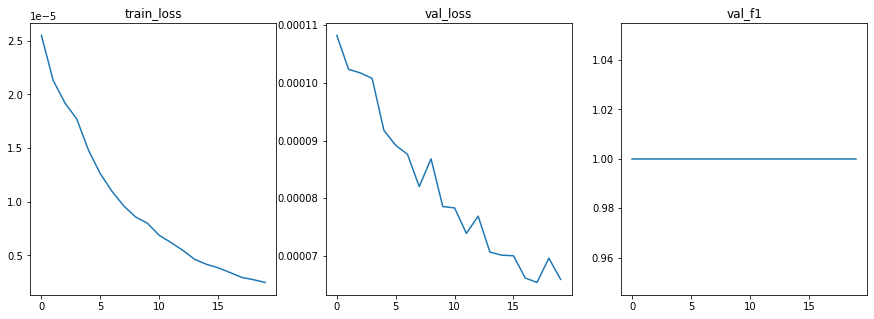

([2.549348014939967e-05,
  2.1304821002507943e-05,
  1.9200985578852728e-05,
  1.7712189269766468e-05,
  1.4798030438955363e-05,
  1.261432832629754e-05,
  1.096040416267018e-05,
  9.604449051460946e-06,
  8.58667422324983e-06,
  8.001343450055839e-06,
  6.880971816346492e-06,
  6.2035087128432664e-06,
  5.4845420056301844e-06,
  4.647720417326863e-06,
  4.180724086802073e-06,
  3.856012291292787e-06,
  3.42026724186152e-06,
  2.9591581328135914e-06,
  2.7462577500071427e-06,
  2.4883218816476685e-06],
 [0.00010824510363818262,
  0.00010235163582466258,
  0.00010172679632584429,
  0.00010077790959460092,
  9.176571583743174e-05,
  8.9171875424654e-05,
  8.76149388053212e-05,
  8.201515756809386e-05,
  8.683751217025323e-05,
  7.855144768503427e-05,
  7.832579833828074e-05,
  7.389294639021197e-05,
  7.689383332439724e-05,
  7.066023580364345e-05,
  7.012461320401699e-05,
  7.001539445102227e-05,
  6.616014991828302e-05,
  6.539281691857468e-05,
  6.960313930019564e-05,
  6.592078962499

In [ ]:
train_eval(model, train_iterator, val_iterator, optimizer, criterion)